# CNNs (Convolutional Neural Networks)

In this notebook, will will introduce the concept, define and then get familiar with neural networks.
Neural networks are a subfield of machine learning and are what we commonly think of when mentioning deep learning algorithms. Their name "neural networks" refers to the fact that the idea behind the algorith was inspired by the human brain, specifically by the way biological neurons exchange information.

<img src="https://github.com/albarqounilab/EEDA-Autumn-School/raw/main/images/nn.jpg" width="400">

We will start with multilayer perceptrons and work up to convolutional neural networks, one of the most popular types of neural networks.

# Multilayer Perceptrons (18 mins)

## Introduction (5 min)

The traditional definition for an MLP is "A multilayer perceptron (MLP) is a stack of perceptrons, each of which involved the non-differentiable Heaviside function. This makes such models difficult to train, which is why they were never widely used. MLP is also defined as a fully connected class of feedforward neural network."

To get comfortable with the concept, check out the image from [TensorFlow's interactive demo - "Tinker With a Neural Network Right Here in Your Browser."](https://playground.tensorflow.org/)

![img](https://github.com/albarqounilab/EEDA-Autumn-School/raw/main/images/vsxnkaR.png)

We will start on the MNIST dataset, which you are already familiar with from the previous notebook.
However, for the purpose of training a neural network it is often convenient to put the dataset into a DataLoader format, which delivers data to the model a few data points at a time (they are called batches).

## Multi-Layer Perceptron for MNIST Classification¶

Let's import the necessary libraries for working with data and PyTorch.
Torch is the library related to the neural network.
You will recognise numpy from the previous notebooks.

In [1]:
import torch
import numpy as np

import warnings
#Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Load and Visualize the Data (5 mins)

The first step is to download and load the MNIST dataset, just like in the previous notebook.
We will create separate DataLoaders for the training and test datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


To see how the DataLoader format works and check that we have done it correctly, let's visualize a batch of training data:

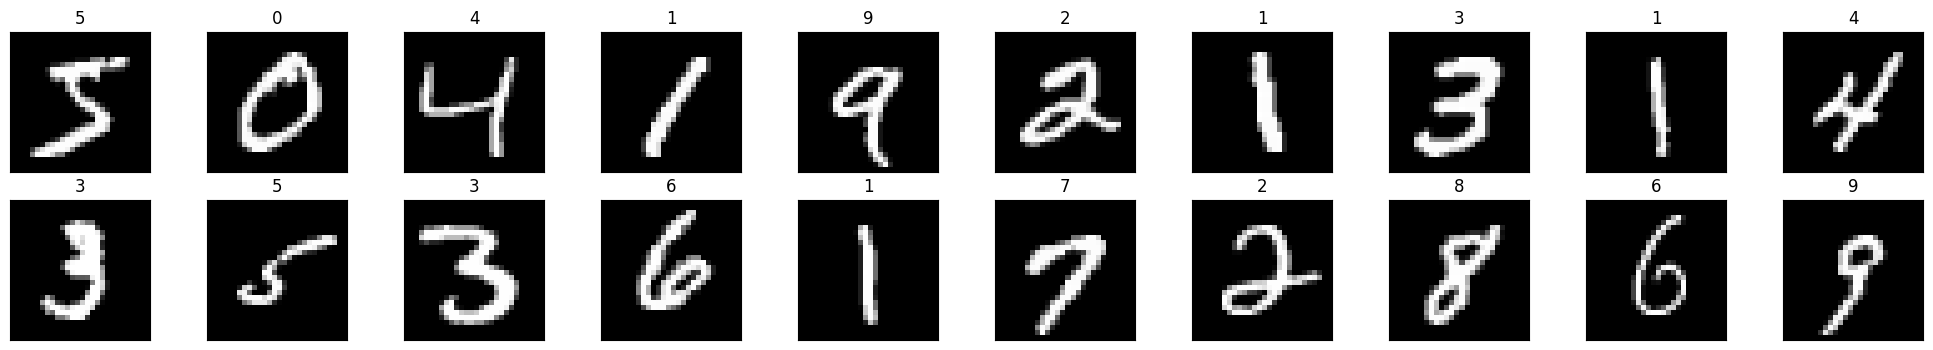

In [3]:
import matplotlib.pyplot as plt

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images in the batch, along with the true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

The key idea is to either flatten the image into a
fixed-dimensional vector for the rest of th training process.

### Define the Network Architecture¶ (1 min)

We will define our MLP architecture. For this example, we will use two hidden layers and ReLU (rectified linear unit) activation to avoid overfitting.

Overfitting, for reference, is a type of error in machine learning or statistics, which happens when a model is too perfectly fitted to a limited set of data points. The negative consequence is that the model is only useful on the training data set, and does not generalise on any other data sets.

For more information on overfitting, see https://www.investopedia.com/terms/o/overfitting.asp.

A rectified linear unit (ReLU) is an activation function that introduces the property of nonlinearity to a deep learning model and solves the vanishing gradients issue.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Linear layers
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        # Flatten image input
        x = x.view(-1, 28 * 28)
        # Add hidden layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer with logits (no activation)
        x = self.fc3(x)
        return x

# Initialize the MLP
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)


### Specify Loss Function and Optimizer (1 min)

Key elements of defining and training a model is choosing a loss function (the value that the model will try to minimise during the training process), optimiser (the algorithm which defines how the model is updated) and connected learning rate. We need to be careful in how we choose the learning rate in order to achieve
convergence. Choosing the learning rate is a critical aspect of training machine learning models, especially in deep learning. The learning rate determines the step size at which the model updates its parameters during training. If the learning rate is too small, the model may converge very slowly, while if it's too large, the model might not converge at all or even diverge.

<img src="https://github.com/albarqounilab/EEDA-Autumn-School/raw/main/images/Eyh0mH4.png" width="400">

Source: https://cs231n.github.io
        
For classification tasks, cross-entropy loss is commonly used, along with an optimizer like stochastic gradient descent (SGD), which is the basic option,  or Adam, which is most often used. For more details on optimisers, see https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

![image](https://github.com/albarqounilab/EEDA-Autumn-School/raw/main/images/opt.gif)

In [5]:
#Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Train the Network (3 min)

Now, we will train our model for a certain number of epochs (which is defined by the model having trained on every data point exactly once), monitoring the training loss. The model will learn to classify the hand-written digits from the training data.

In [6]:
# Number of epochs to train the model
n_epochs = 5

model.train()  # Prep model for training

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0

    # Train the model
    for data, target in train_loader:
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Perform a single optimization step
        train_loss += loss.item() * data.size(0)  # Update running training loss

    # Print training statistics
    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.dataset)

    print('Epoch: {}\tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

#ToDo: train on GPU (double check)

Epoch: 1	Training Loss: 0.322427
Epoch: 2	Training Loss: 0.134132
Epoch: 3	Training Loss: 0.099437
Epoch: 4	Training Loss: 0.081170
Epoch: 5	Training Loss: 0.067800


### Test the Trained Network (1 min)

Finally, we will test our trained model on the test dataset and evaluate its performance.

In [7]:
# Initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # Prep model for evaluation

for data, target in test_loader:
    output = model(data)  # Forward pass
    loss = criterion(output, target)  # Calculate the loss
    test_loss += loss.item() * data.size(0)  # Update test loss
    _, pred = torch.max(output, 1)  # Convert output probabilities to predicted class

    correct = np.squeeze(pred.eq(target.data.view_as(pred)))  # Compare predictions to true label

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate and print average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {:.2f}% ({}/{})'.format(
            str(i), 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of {}: N/A (no training examples)'.format(str(i)))

print('\nTest Accuracy (Overall): {:.2f}% ({}/{})'.format(
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.132335

Test Accuracy of 0: 99.08% (971.0/980.0)
Test Accuracy of 1: 99.65% (1131.0/1135.0)
Test Accuracy of 2: 97.19% (1003.0/1032.0)
Test Accuracy of 3: 97.23% (982.0/1010.0)
Test Accuracy of 4: 97.96% (962.0/982.0)
Test Accuracy of 5: 97.53% (870.0/892.0)
Test Accuracy of 6: 92.69% (888.0/958.0)
Test Accuracy of 7: 92.90% (955.0/1028.0)
Test Accuracy of 8: 94.97% (925.0/974.0)
Test Accuracy of 9: 95.54% (964.0/1009.0)

Test Accuracy (Overall): 96.51% (9651.0/10000.0)


### Visualize Sample Test Results (1 min)

Let us visualize some sample test results to see how well the model performs:

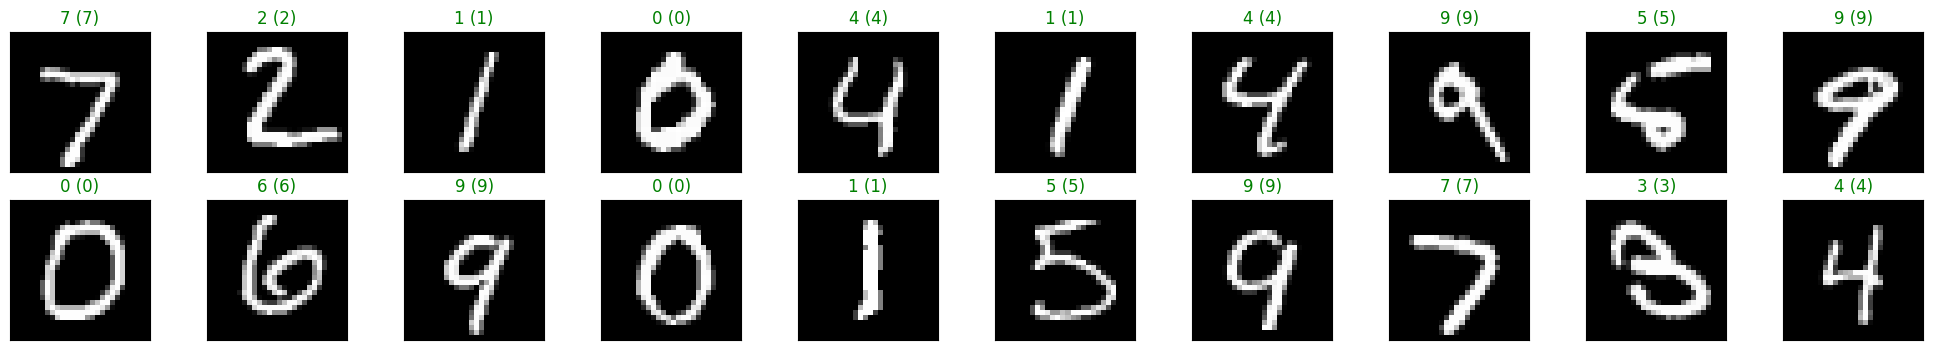

In [8]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get sample outputs
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx] == labels[idx] else "red"))


## Bonus Exercise 1: Improving the Model (10 min)

Now that you have trained the model, there are several ways you can further improve it and fine-tune its performance. Here are some exercises you can try:


1.   Implement a Validation Scheme: Currently, the model is trained only on the
training dataset. You can implement a validation scheme by splitting the training dataset into training and validation sets. This will allow you to monitor the model's performance on unseen data during training and help you avoid overfitting.
2.   Hyperparameter Tuning: Experiment with different hyperparameters, such as learning rate, number of hidden layers, number of neurons in each layer, batch size, and number of training epochs. Tuning these hyperparameters can significantly impact the model's performance.

ImprovedNet(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch: 1 	Training Loss: 0.363607 	Validation Loss: 0.250912
Validation loss decreased (inf --> 0.250912).  Saving model ...
Epoch: 2 	Training Loss: 0.228640 	Validation Loss: 0.164348
Validation loss decreased (0.250912 --> 0.164348).  Saving model ...
Epoch: 3 	Training Loss: 0.196350 	Validation Loss: 0.140010
Validation loss decreased (0.164348 --> 0.140010).  Saving model ...
Epoch: 4 	Training Loss: 0.181675 	Validation Loss: 0.138129
Validation loss decreased (0.140010 --> 0.138129).  Saving model ...
Epoch: 5 	Training Loss: 0.171455 	Validation Loss: 0.129080
Validation loss decreased (0.138129 --> 0.129080).  Saving model ...
Test Loss: 0.115569

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 97% (1111/1135)
Test Accu

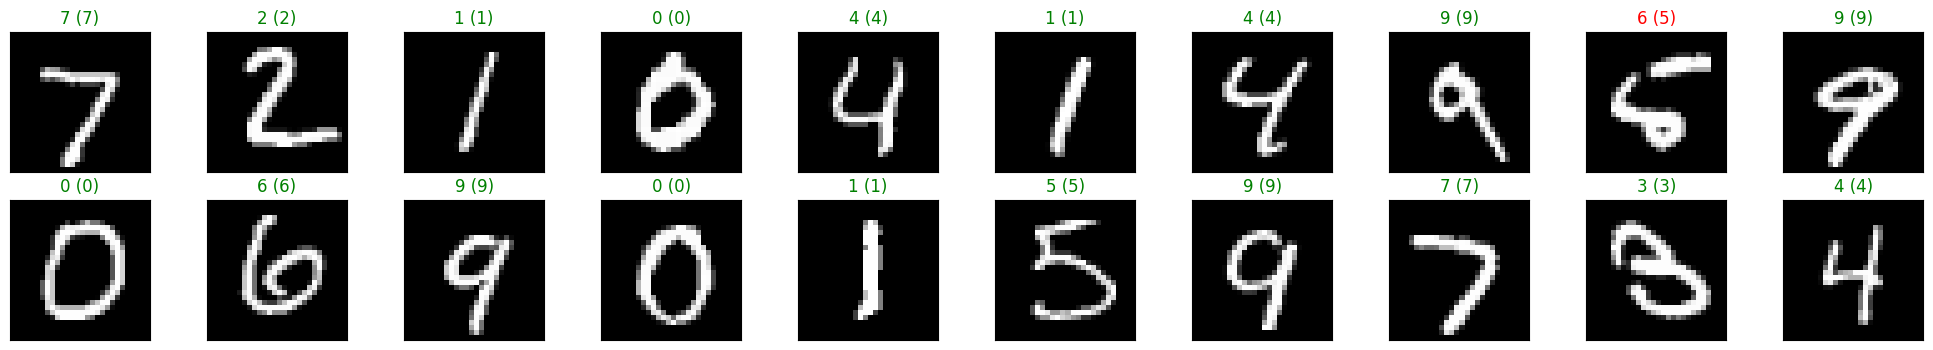

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 20
# Percentage of training set to use as validation
valid_size = 0.2

# Convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)


# Define the NN architecture
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        # Number of hidden nodes in each layer
        hidden_1 = 1024
        hidden_2 = 1024
        # Linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # Linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # Linear layer (hidden_2 -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # Dropout layer (p=0.2)
        # Dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Flatten image input
        x = x.view(-1, 28 * 28)
        # Add hidden layer with Leaky ReLU activation function
        x = F.leaky_relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add hidden layer with Leaky ReLU activation function
        x = F.leaky_relu(self.fc2(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add output layer
        x = self.fc3(x)
        return x

# Initialize the NN
improved_model = ImprovedNet()
print(improved_model)

# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer (Adam) and learning rate = 0.001
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

# Number of epochs to train the model
n_epochs = 5
valid_loss_min = np.Inf

# Implement validation scheme
for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    improved_model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = improved_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validate the model
    improved_model.eval()
    for data, target in valid_loader:
        output = improved_model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, train_loss, valid_loss))

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, valid_loss))
        torch.save(improved_model.state_dict(), 'improved_model.pt')
        valid_loss_min = valid_loss

# Load the model with the lowest validation loss
improved_model.load_state_dict(torch.load('improved_model.pt'))

# Test the trained network
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

improved_model.eval()
for data, target in test_loader:
    output = improved_model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Visualize sample test results
dataiter = iter(test_loader)
images, labels = next(dataiter)
output = improved_model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx] == labels[idx] else "red"))


## Bonus Excercise 2: CNNs Applications

Convolutional Neural Networks (CNNs) have revolutionized the world of image processing and computer vision. you can explore interactive playgrounds and applications that showcase their remarkable capabilities. let's dive in a couple of examples to understand what CNNs can do:
Playgrounds:
Image Convolution Playground Experiment with complex image processing operations in your browser.
CNN vision Draw numbers and inspect layers.
Image kernels Image Kernels Explained Visually
Image Convolution Playground Experiment with complex image processing operations in your browser.
Play with CNNs:
Quick draw Play pictionary with a CNN!
AutoDraw CNN helps you draw!



# Convolutional Neural Network (CNN) for CIFAR10 Classification (30-50 min)

In this excercise, we will build a deep learning Convolutional Neural Network (CNN) model to classify images of the CIFAR10 dataset, a commonly used dataset in computer vision. Your task is to complete each code cell by filling in the appropriate portion of the code. Each cell contains a partial code snippet, and your goal is to provide the missing code to set up the pipeline.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

![title](https://github.com/albarqounilab/EEDA-Autumn-School/raw/main/images/cifar.png)

### Import packages for the notebook

In this step, we import the necessary packages for our task. The essential packages used in this notebook are:

- numpy as np: NumPy is a fundamental package for scientific computing in Python. We use it for numerical operations and array manipulations.
- torch: This is the PyTorch library, which is a popular deep learning framework for building and training neural networks.
- torch.nn: This module contains all the necessary functions and classes for building neural networks in PyTorch.
- torch.optim: This module contains various optimization algorithms used for training neural networks.
- torch.utils.data.DataLoader: This class is used to load data efficiently for training and validation.
- torchvision.transforms: This module provides common image transformations like resizing, cropping, and normalization.

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Define a transformation

You may add your prefered choices from trasform. library or leave it as it is.

In [11]:
# Data transformation defined
transform = transforms.Compose([
    # you may add more transformations here...
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

### Load the CIFAR-10 dataset (~ 5 min)
In the following code snippet, you'll see the initial setup for loading the CIFAR-10 dataset. Your task is setting up the data transformation, splitting the dataset into training and validation sets, and creating data loaders:

- Calculate the size for the training set and validation set with len()
- Split the training dataset into train and validation sets using random_split from torch.utils.data
- Create data loaders for the training, validation, and test sets using DataLoader from torch.utils.data

In [12]:
# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Calculate the size for the training set and validation set with len()
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the training dataset into train and validation sets using random_split from torch.utils.data
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders for the training, validation, and test sets using DataLoader from torch.utils.data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


### Plot the dataloader data (1 min)
Now the train_loader, val_loader, and test_loader are ready to be used for training and evaluation.

Lets plot some images: its a good practice to view the data before using it as input to the model.



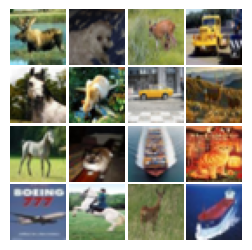

In [13]:
def plot_batch_images(data_loader, grid_size=(5, 5)):
    # Get a random batch of data
    batch_images, _ = next(iter(data_loader))

    # Denormalize the images
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    denormalized_images = batch_images.cpu().numpy() * std[:, None, None] + mean[:, None, None]
    denormalized_images = np.clip(denormalized_images, 0, 1)  # Clip values to [0, 1]

    # Create a grid of images
    num_rows, num_cols = grid_size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3, 3))

    for i in range(num_rows):
        for j in range(num_cols):
            image = denormalized_images[i * num_cols + j].transpose(1, 2, 0)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Call the function to plot random images from the train_loader in a 5x5 grid
plot_batch_images(train_loader, (4,4))

### Define the CNN architecture (10-15 min)

Below, you'll find the initial code to define the neural network model. Your task is to complete the Net class by adding the missing layers and connections as described in the comments. You'll be implementing a simple convolutional neural network (CNN) architecture.

Your Task:
Fill in the missing portions of the code in the cell below to complete the neural network model definition.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # First fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 8, 128)  # Adjusted input size based on the architecture
        # Second fully connected layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First convolutional layer followed by activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Second convolutional layer followed by activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape the tensor before passing through the fully connected layers
        x = x.view(-1, 128 * 8 * 8)
        # First fully connected layer followed by activation
        x = F.relu(self.fc1(x))
        # Second fully connected layer
        x = self.fc2(x)
        return x

# Create an instance of the Net class
model = Net()


In [15]:
from torchsummary import summary
# summary(model, (3, 32, 32))

#### Define optimizer and loss function (1 min)
Below, you'll find a code snippet to define the optimizer and loss function. Your task is to complete the code by filling in the appropriate optimizer and loss function classes along with the required hyperparameters.

#### Your Task:
Fill in the missing portions of the code in the cell below to set up the optimizer and loss function.

In [16]:
import torch.optim as optim

# Define optimizer and loss function
# ToDo:
# 1. Create an instance of the Adam optimizer and pass the model parameters and learning rate (lr=0.001)
# 2. Create an instance of the CrossEntropyLoss loss function

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Uncomment the following lines to print the optimizer and loss function details
print("Optimizer:", optimizer)
print("Loss Function:", criterion)


Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss Function: CrossEntropyLoss()


### Train the model (10-15 min)
Below, you'll find a code snippet with placeholders for the training and validation loops. Your task is to complete the code by filling in the missing portions to implement the training and validation process.

#### Your Task:
Fill in the missing portions of the code in the cell below to complete the training and validation loops.

In [17]:
import torch

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # ToDo:
        # 1. Compute the loss using the criterion (loss function)
        # 2. Perform backpropagation to compute gradients .backward()
        # 3. Update model parameters using the optimizer .step()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    correct = 0


    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # ToDo:
            # 4. Compute validation loss and accumulate it
            # 5. Calculate the number of correct predictions and accumulate it
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {correct/len(val_loader.dataset):.4f}')

Epoch 1, Validation Loss: 0.0497, Validation Accuracy: 0.6528
Epoch 2, Validation Loss: 0.0450, Validation Accuracy: 0.6948
Epoch 3, Validation Loss: 0.0459, Validation Accuracy: 0.7059
Epoch 4, Validation Loss: 0.0541, Validation Accuracy: 0.6916
Epoch 5, Validation Loss: 0.0686, Validation Accuracy: 0.6625


### Test the model (1 min)
Below, you'll find a code snippet to test the trained model on the test set. Your task is to complete the code by filling in the missing portions to calculate and print the test loss and accuracy.

#### Your Task:
Fill in the missing portions of the code in the cell below to complete the testing process.

In [18]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # ToDo:
        # 1. Compute the test loss using the criterion (loss function)
        # 2. Calculate the number of correct predictions and accumulate it

        test_loss = criterion(output, target)
        correct += (output[:].argmax() == target[:]).float().sum()

        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {correct/len(test_loader.dataset):.4f}')

Test Loss: 0.0003, Test Accuracy: 0.6748


Below, you'll find a code snippet to redefine the data transformations and adjust the batch size. Your task is to complete the code by replacing the existing transformation setup with the enhanced transformations and updating the batch size.

#### Your Task (15 min):
Replace the existing data transformation setup with the provided enhanced transformations and adjust the batch size to complete the code in the cell below.

In [19]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

# Import the CIFAR dataset
transform_train = transforms.Compose([
    # ToDo:
    # 1. Add a RandomCrop transformation with padding of 4
    # 2. Add a RandomHorizontalFlip transformation
    # 3. Transform the image to a tensor and normalize it

    transforms.RandomCrop((32, 32), padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([ # Test set normally remains untouched from sophisticated transformations
    # Transform the image to a tensor and normalize it

    # ToDo:
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Adjust the batch size
batch_size = 32

# Calculate the size for the training set and validation set with len()
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_size = len(test_dataset)

# Split the training dataset into train and validation sets using random_split from torch.utils.data
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders for the training, validation, and test sets using DataLoader from torch.utils.data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


Below, you'll find a code snippet to load the pretrained ResNet-18 model and set up the training components. Your task is to complete the code by adding the missing parts to define the optimizer, loss function, and modify the fully connected layer for 10 classes.

#### Your Task (25 min):
Complete the code in the cell below by defining the optimizer and loss function, as well as modifying the fully connected layer of the pretrained ResNet-18 model to match the 10 classes of the CIFAR-10 dataset.

In [32]:
import torchvision.models as models

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
# ToDo:
# 1. Modify the fully connected layer to output 10 classes nn.Linear()

model.fc = nn.Linear(512, 10)

# Define optimizer and loss function
# Your task:
# 2. Create an instance of the Adam optimizer and pass the model parameters and learning rate (lr=0.001)
# 3. Create an instance of the CrossEntropyLoss loss function or you may use another

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Send model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here we'll enhance the training process by incorporating logging of training and validation metrics. Additionally, we'll integrate the tqdm library to provide a progress bar that gives feedback on the training process. Additionally, we will create informative plots that illustrate the model's performance during training.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define the number of epochs
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()

        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_accuracy = train_correct / train_total
    train_loss_avg = train_loss_total / len(train_loader)

    model.eval()
    val_loss_total = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in tqdm(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss_total += loss.item()

            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_accuracy = val_correct / val_total
    val_loss_avg = val_loss_total / len(val_loader)

    # Append metrics to lists
    train_losses.append(train_loss_avg)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss_avg:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}')

100%|██████████| 313/313 [00:06<00:00, 51.94it/s]


Epoch 1, Train Loss: 1.2974, Train Accuracy: 0.5535, Validation Loss: 1.1312, Validation Accuracy: 0.6053


100%|██████████| 313/313 [00:05<00:00, 57.05it/s]


Epoch 2, Train Loss: 0.9935, Train Accuracy: 0.6624, Validation Loss: 0.8873, Validation Accuracy: 0.6958


100%|██████████| 313/313 [00:05<00:00, 57.94it/s]


Epoch 3, Train Loss: 0.8578, Train Accuracy: 0.7104, Validation Loss: 0.7951, Validation Accuracy: 0.7276


100%|██████████| 313/313 [00:06<00:00, 51.31it/s]


Epoch 4, Train Loss: 0.8232, Train Accuracy: 0.7196, Validation Loss: 0.7020, Validation Accuracy: 0.7531


100%|██████████| 313/313 [00:05<00:00, 55.96it/s]

Epoch 5, Train Loss: 0.7391, Train Accuracy: 0.7517, Validation Loss: 0.7114, Validation Accuracy: 0.7576


Here's how we can to plot the metrics stored before:

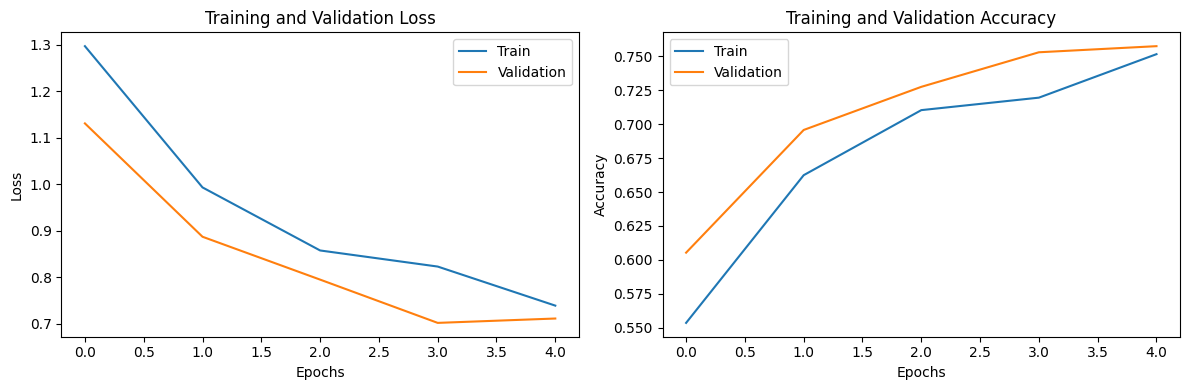

In [22]:
def plot_loss_and_accuracy(epochs_range, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train')
    plt.plot(epochs_range, val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train')
    plt.plot(epochs_range, val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Usage
plot_loss_and_accuracy(range(num_epochs), train_losses, val_losses, train_accuracies, val_accuracies)


Here we'll enhance the previous test process by integrating the tqdm library to provide a progress bar that gives feedback on the testing process.

In [23]:
# Test the model
model.eval()
test_loss_total = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss_total += loss.item()

        _, predicted = output.max(1)
        test_total += target.size(0)
        test_correct += predicted.eq(target).sum().item()

test_accuracy = test_correct / test_total
test_loss_avg = test_loss_total / len(test_loader)

print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.4f}')


100%|██████████| 313/313 [00:04<00:00, 72.91it/s]

Test Loss: 0.7096, Test Accuracy: 0.7680


### Visualise test (5 mins)
Let us  visualise the results (similar to how we did for the MNIST dataset)

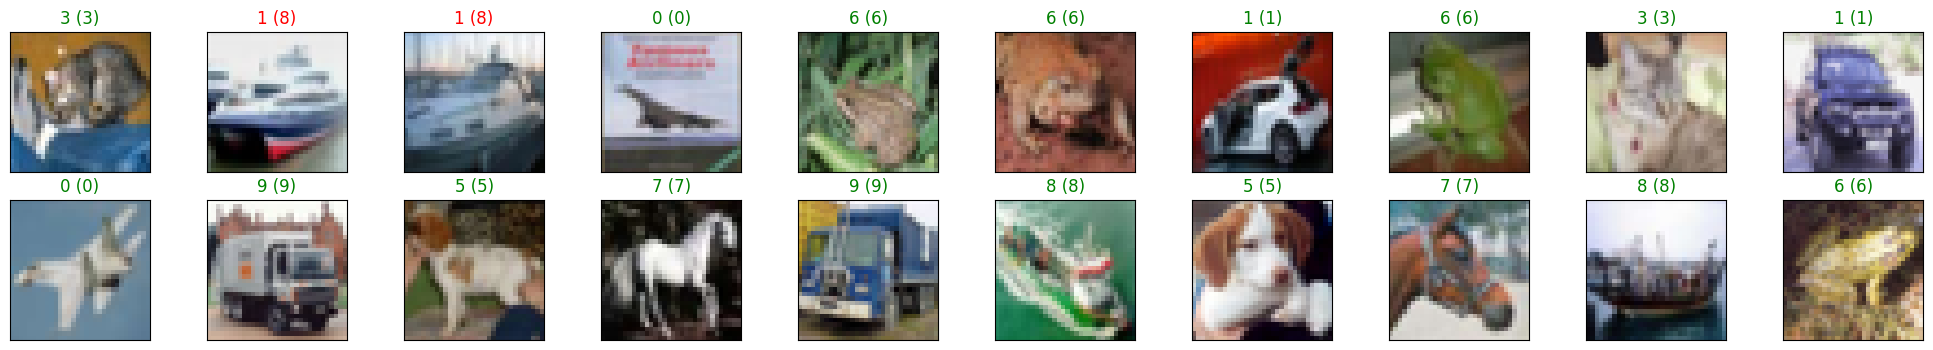

In [24]:
#ToDo: visualise 20 images with titles containing the predicted and actual class. Print in green if they are the same, red otherwise.
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to device
images = images.to(device)

# Get sample outputs
output = model(images)
_, preds = torch.max(output, 1)

# Move images back to CPU and convert to numpy
images = images.cpu().numpy().transpose(0, 2, 3, 1)

# Invert normalization to bring images back to the original scale
images = (images / 2) + 0.5

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(images[idx].squeeze(), cmap='gray')  # Assuming images are grayscale
    title_color = "green" if preds[idx] == labels[idx] else "red"
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=title_color)

plt.show()



### Save your trained model

Here's how you can save and load the trained model using PyTorch's torch.save() and torch.load() functions:

Saving the Model:

In [25]:
# Save the trained model
torch.save(model.state_dict(), 'model.pth')


To load the model later:



In [26]:
# Load the saved model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Change the fully connected layer for 10 classes

model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

### Going the Extra Mile: Fine-Tuning a Pretrained Model (5 mins)

In this advanced exercise, you'll take your training process to the next level by performing fine-tuning on a pre-trained model. Fine-tuning involves adjusting the weights of the pre-trained model to better fit the specific dataset you're working with. This approach can lead to improved performance on your target task.

Below, you'll find a code snippet that demonstrates the process of fine-tuning a pre-trained model on the CIFAR-10 dataset. Your task is to run this code to fine-tune the model and observe any improvements in training and validation metrics.

First we freeze the last _ layers

In [27]:
# Freeze all layers except the last # layers
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True


Then we use a smaller learning rate

In [28]:
# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Now we train again

100%|██████████| 313/313 [00:06<00:00, 49.31it/s]


Epoch 1, Train Loss: 0.6762, Train Accuracy: 0.7678, Validation Loss: 0.6711, Validation Accuracy: 0.7677


100%|██████████| 313/313 [00:06<00:00, 49.52it/s]


Epoch 2, Train Loss: 0.6779, Train Accuracy: 0.7719, Validation Loss: 0.6764, Validation Accuracy: 0.7649


100%|██████████| 313/313 [00:06<00:00, 51.18it/s]


Epoch 3, Train Loss: 0.6733, Train Accuracy: 0.7725, Validation Loss: 0.6710, Validation Accuracy: 0.7706


100%|██████████| 313/313 [00:06<00:00, 51.52it/s]


Epoch 4, Train Loss: 0.6774, Train Accuracy: 0.7704, Validation Loss: 0.6956, Validation Accuracy: 0.7659


100%|██████████| 313/313 [00:05<00:00, 54.02it/s]


Epoch 5, Train Loss: 0.6700, Train Accuracy: 0.7745, Validation Loss: 0.6723, Validation Accuracy: 0.7652


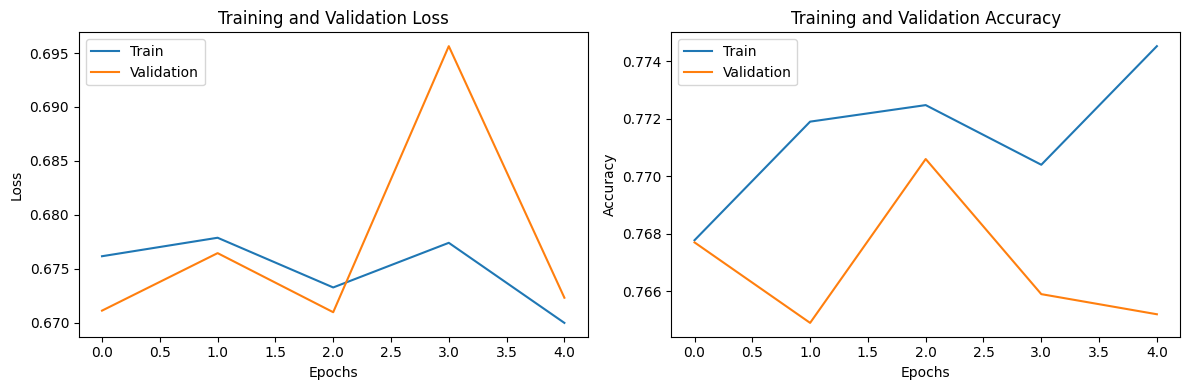

100%|██████████| 313/313 [00:04<00:00, 70.34it/s]

Test Loss: 0.6579, Test Accuracy: 0.7811


In [29]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define the number of epochs
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()

        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_accuracy = train_correct / train_total
    train_loss_avg = train_loss_total / len(train_loader)

    model.eval()
    val_loss_total = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in tqdm(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss_total += loss.item()

            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_accuracy = val_correct / val_total
    val_loss_avg = val_loss_total / len(val_loader)

    # Append metrics to lists
    train_losses.append(train_loss_avg)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss_avg:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Usage
plot_loss_and_accuracy(range(num_epochs), train_losses, val_losses, train_accuracies, val_accuracies)

# Test the model
model.eval()
test_loss_total = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss_total += loss.item()

        _, predicted = output.max(1)
        test_total += target.size(0)
        test_correct += predicted.eq(target).sum().item()

test_accuracy = test_correct / test_total
test_loss_avg = test_loss_total / len(test_loader)

print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.4f}')


In this comprehensive exercise, you've worked through a complete deep learning workflow using the CIFAR-10 dataset. You've covered data preprocessing, model definition, training, validation, testing, and advanced techniques like fine-tuning and visualizing performance metrics. This exercise aimed to provide you with a hands-on experience in building and training neural networks using PyTorch.

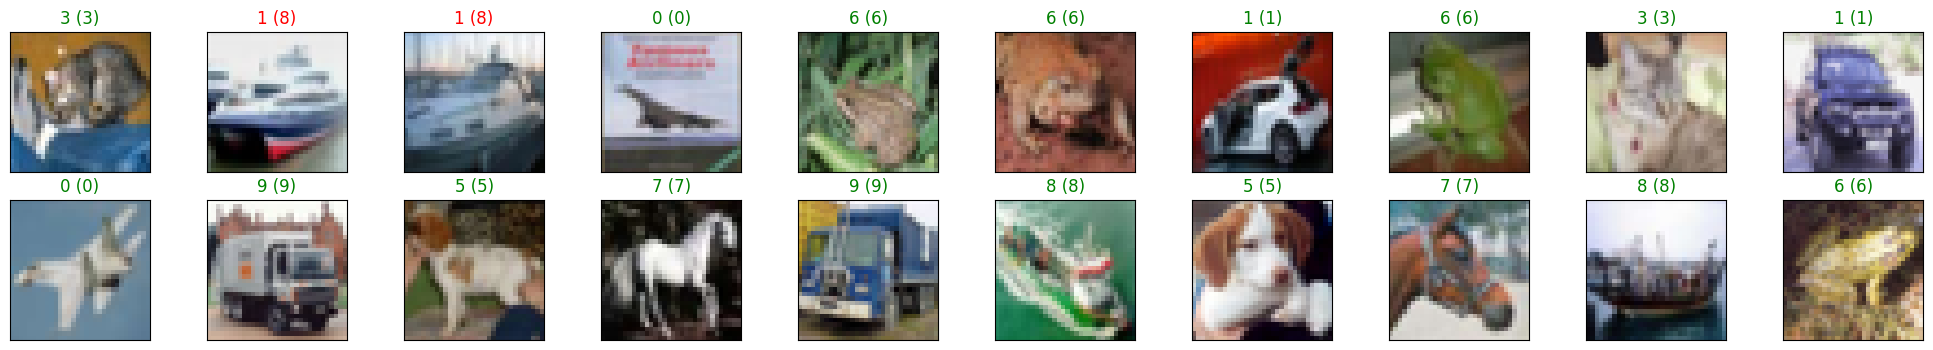

In [30]:
#ToDo: visualise 20 images with titles containing the predicted and actual class. Print in green if they are the same, red otherwise.
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get sample outputs
output = model(images.to(device))
_, preds = torch.max(output, 1)
images = images.numpy()
images = images.transpose(0, 2, 3, 1)

# Invert normalization to bring images back to the original scale
images = (images / 2) + 0.5

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx] == labels[idx] else "red"))

plt.show()

